In [1]:
# Numpy imports:
import numpy as np

#Scipy imports
import scipy
from scipy import optimize
from scipy.optimize import curve_fit

# for extracting filenames
import glob

# skimage submodules we need
import skimage.io
import skimage.measure
import skimage.filters
import skimage.exposure
import skimage.morphology
from skimage.registration import phase_cross_correlation

#For identifying aster center
from skimage.filters import threshold_otsu, gaussian
from skimage.measure import regionprops
import cv2

#Matplotlib imports
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

# # Seaborn imports (stylistic for nice plots)
# import seaborn as sns
# rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14, \
#     'xtick.labelsize' : 14, 'ytick.labelsize' : 14}
# sns.set(style='ticks', rc=rc)

#for DataFrames
import pandas as pd

#To interact with the operating system
import os

#For status bar 
from tqdm.notebook import tqdm as tqdm

In [2]:
import atp_hydro
atp_hydro.pboc_style_mpl()
# show images in viridis by default (pboc is fire?)
plt.rcParams['image.cmap'] = 'viridis'

## Settings and Functions

#### Image Plotting Settings

In this cell I specify the size of images and the conversion of pixels to µm. 

In [3]:
# Length calibration [microns per pixel]
um_per_pixel = 0.58 #Jan2023 um_per_pixel corrected s.t. it is assuming 10X mag rather than 5X (now don't have to divide by 2)

# Image dimensions
w_px, h_px = 1920, 1200
w_um, h_um = w_px*um_per_pixel, h_px*um_per_pixel

#bounds
bounds = [0, 0, w_um, h_um]

#Set the frame size of the image to enforce square pixels (holoviews does not have this preset)
frame_height = 200
frame_width = w_px * frame_height // h_px

#Preset these settings as opts
opts = dict(
    frame_height=frame_height,
    frame_width=frame_width,
    xlabel="µm",
    ylabel="µm",
    cmap = 'viridis'
)

## Import Images

In [4]:
#This should not change between experiments:
datapath = '../../data/atp_hydro'

#This varies between experiments.  
datafolder = '2023-11-04_Hydrolysis/470uMATP_60sFramerate/'

# YFP Images
included_YFP = '*YFP*.tif'
YFP_files_batch1 = np.sort(glob.glob(datapath+'/'+datafolder+'/'+included_YFP))
# included_YFP = 'YFP/*Pos1_1*.tif'
# YFP_files_batch2 = np.sort(glob.glob(datapath+'/'+datafolder+'/'+included_YFP))
#YFP_files = np.concatenate((YFP_files_batch1, YFP_files_batch2), axis=0)
YFP_files = np.copy(YFP_files_batch1)

# CFP Images
included_CFP = '*CFP*.tif'
CFP_files_batch1 = np.sort(glob.glob(datapath+'/'+datafolder+'/'+included_CFP))
CFP_files = np.copy(CFP_files_batch1)
# included_CFP = 'CFP/*Pos1_1*.tif'
# CFP_files_batch2 = np.sort(glob.glob(datapath+'/'+datafolder+'/'+included_CFP))
# CFP_files = np.concatenate((CFP_files_batch1, CFP_files_batch2), axis=0)

# # Motor Images
# included_Mot = 'Cherry/*Pos1.*.tif'
# Mot_files_batch1 = np.sort(glob.glob(datapath+'/'+datafolder+'/'+included_Mot))
# included_Mot = 'Cherry/*Pos1_1*.tif'
# Mot_files_batch2 = np.sort(glob.glob(datapath+'/'+datafolder+'/'+included_Mot))
# Mot_files = np.concatenate((Mot_files_batch1, Mot_files_batch2), axis=0)

#Read in images and save as array:
YFP_array = atp_hydro.file_to_image(YFP_files)
CFP_array = atp_hydro.file_to_image(CFP_files)

# ------------------------------------------------------------------------------ #
#Background - use no motor no ATeam no ATP condition from 2023-01-23 Cal Curve
bgfolder = '../../data/atp_cal/2023-01-23_ATeam(new)_CalCurve/2023-01-23_ATeam(new)_CalCurve_1/images/'
YFP_bg = skimage.io.imread(bgfolder + 'C4-2023-01-23_ATeam(new)_CalCurve_1_MMStack_Pos8.ome.tif')
CFP_bg = skimage.io.imread(bgfolder + 'C3-2023-01-23_ATeam(new)_CalCurve_1_MMStack_Pos8.ome.tif')

In [13]:
np.average(YFP_bg)

1919.5998125

In [5]:
len(YFP_array)

400

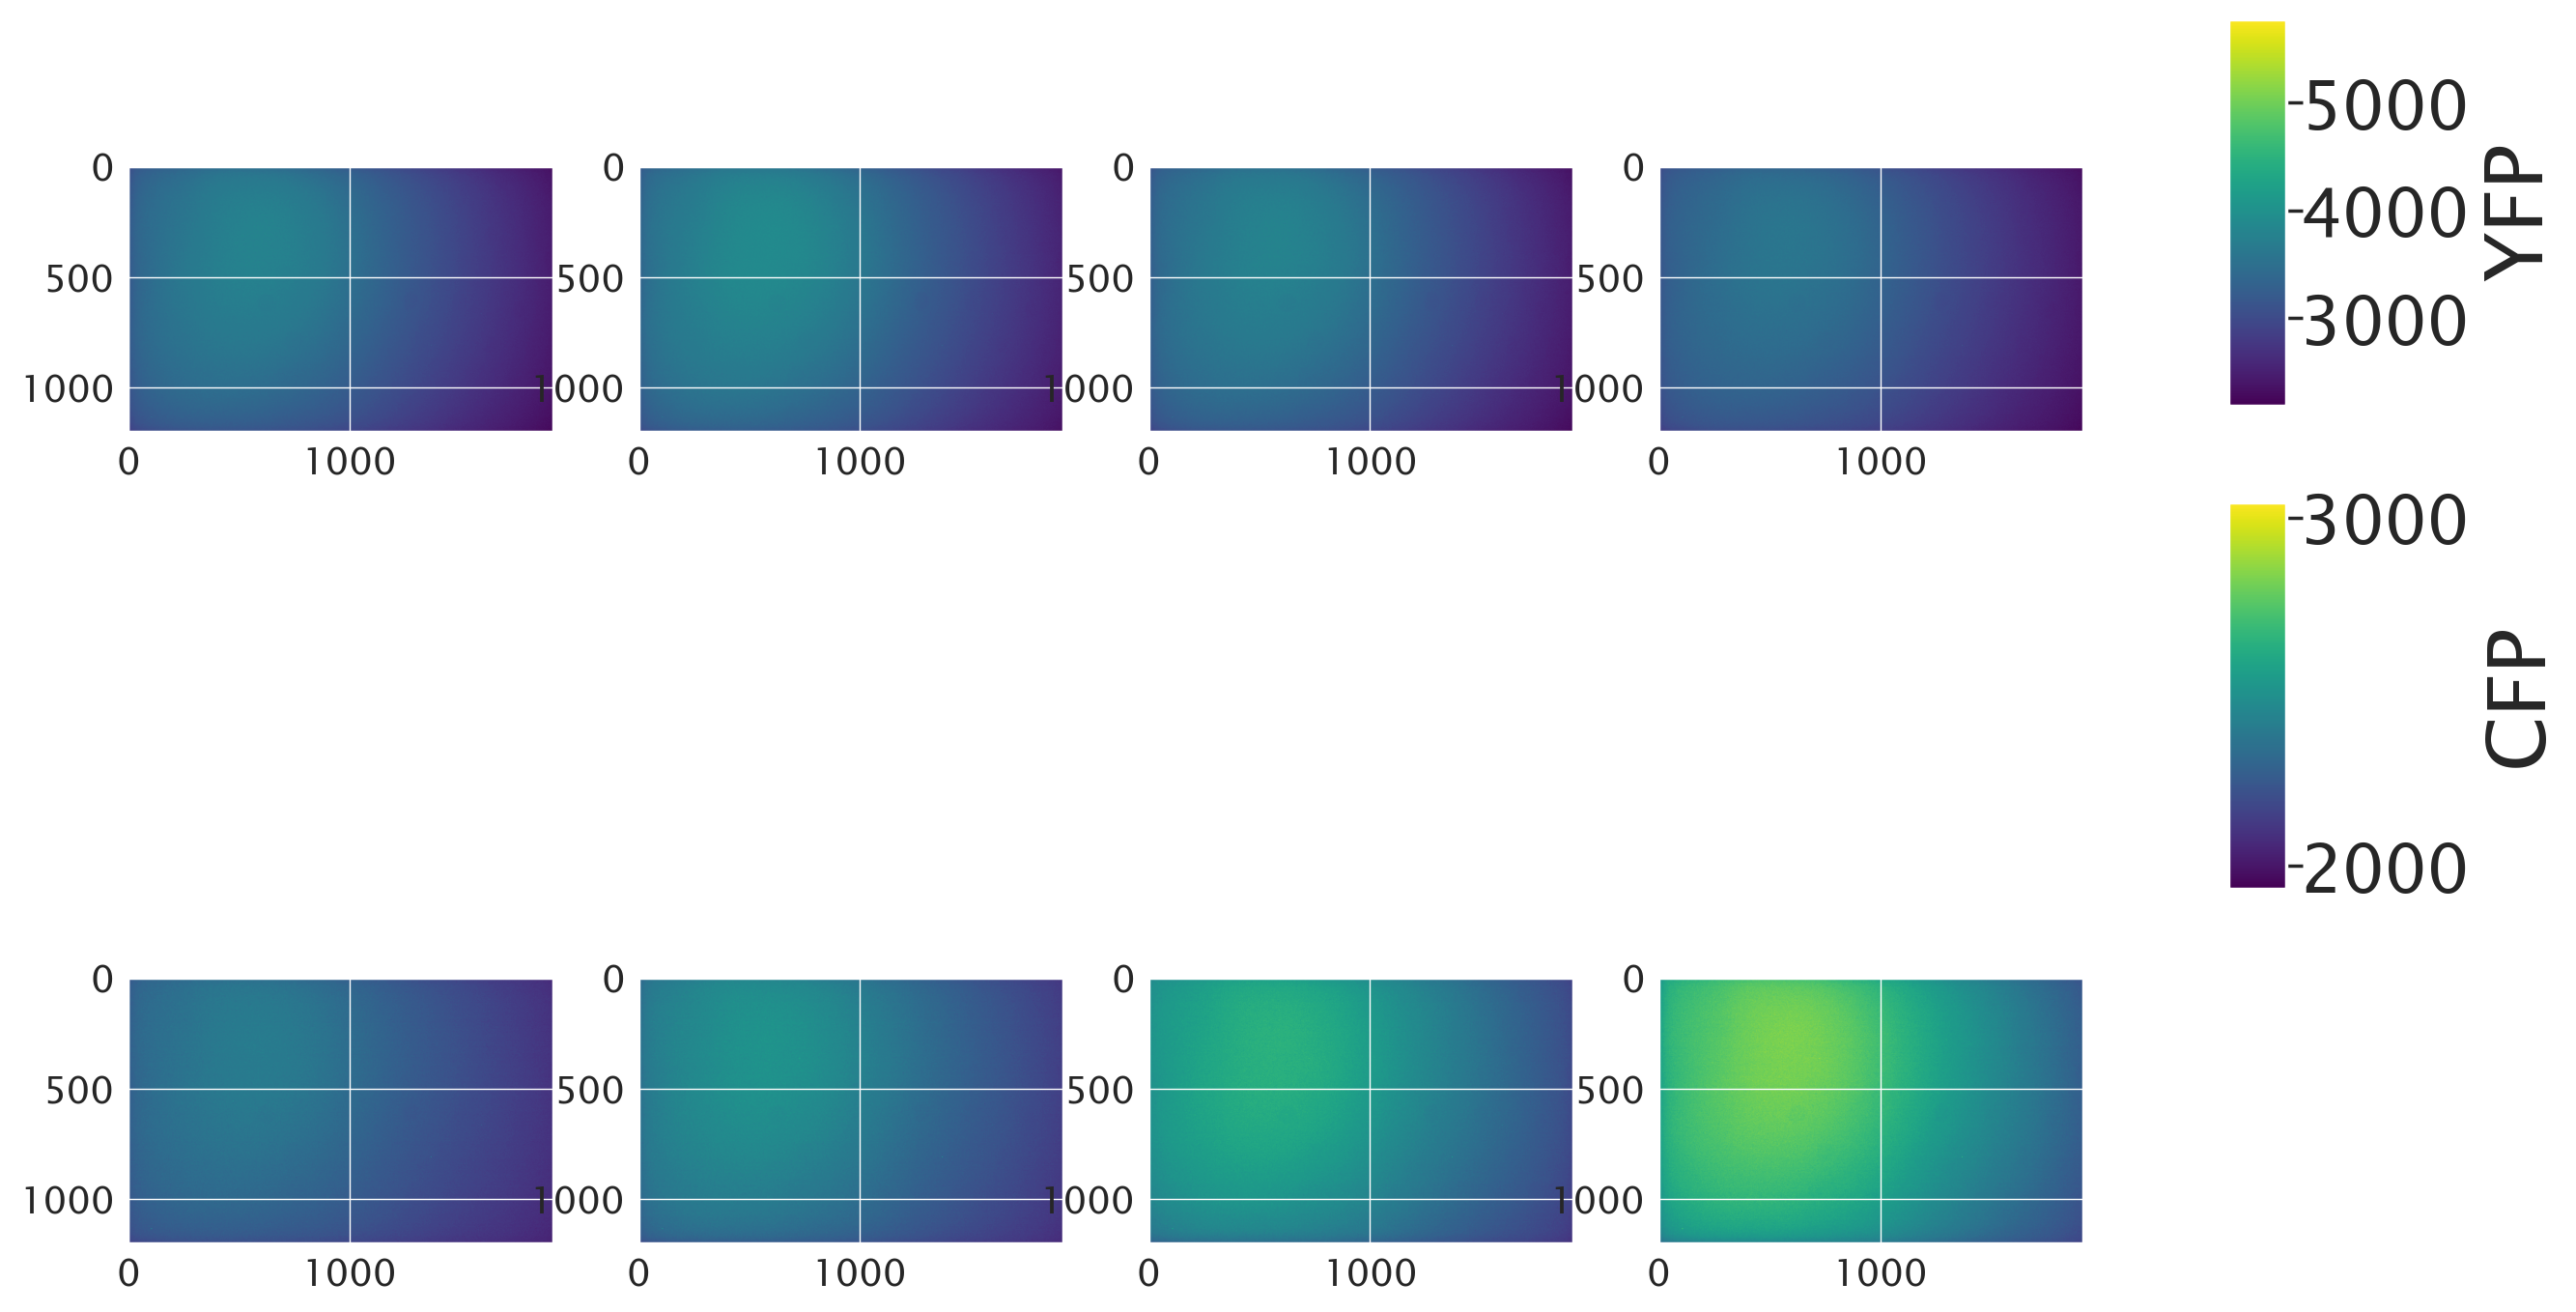

In [6]:
fig, ax = plt.subplots(2, 4, figsize=(15, 10))
ax[0][0].imshow(YFP_array[0])
ax[0][1].imshow(YFP_array[50])
ax[0][2].imshow(YFP_array[90])
ax[0][3].imshow(YFP_array[-1])

ax[1][0].imshow(CFP_array[0], vmin = CFP_array.min(), vmax = 0.55*CFP_array.max())
ax[1][1].imshow(CFP_array[50], vmin = CFP_array.min(), vmax = 0.55*CFP_array.max())
ax[1][2].imshow(CFP_array[90], vmin = CFP_array.min(), vmax = 0.55*CFP_array.max())
ax[1][3].imshow(CFP_array[-1], vmin = CFP_array.min(), vmax = 0.55*CFP_array.max())

# ax[2][0].imshow(Mot_array[0], vmin = Mot_array.min(), vmax = 0.2*Mot_array.max())
# ax[2][1].imshow(Mot_array[150], vmin = Mot_array.min(), vmax = 0.2*Mot_array.max())
# ax[2][2].imshow(Mot_array[300], vmin = Mot_array.min(), vmax = 0.2*Mot_array.max())
# ax[2][3].imshow(Mot_array[-1], vmin = Mot_array.min(), vmax = 0.2*Mot_array.max())

cmap = cm.viridis
normYFP = mcolors.Normalize(vmin=YFP_array.min(), vmax=YFP_array.max())
mapYFP = cm.ScalarMappable(norm=normYFP, cmap=cmap)
normCFP = mcolors.Normalize(vmin=CFP_array.min(), vmax=0.55*CFP_array.max())
mapCFP = cm.ScalarMappable(norm=normCFP, cmap=cmap)
# normMot = mcolors.Normalize(vmin=Mot_array.min(), vmax=0.2*Mot_array.max())
# mapMot = cm.ScalarMappable(norm=normMot, cmap=cmap)


fig.subplots_adjust(right=0.8)
color_bar_ax_YFP = fig.add_axes([0.85, 0.65, 0.02, 0.2])
cbarYFP = fig.colorbar(mapYFP, cax=color_bar_ax_YFP)
cbarYFP.ax.tick_params(labelsize=25)
cbarYFP.set_label(label="YFP", size=30, weight='bold')

color_bar_ax_CFP = fig.add_axes([0.85, 0.4, 0.02, 0.2])
cbarCFP = fig.colorbar(mapCFP, cax=color_bar_ax_CFP)
cbarCFP.ax.tick_params(labelsize=25)
cbarCFP.set_label(label="CFP", size=30, weight='bold')

# color_bar_ax_Mot = fig.add_axes([0.85, 0.13, 0.02, 0.2])
# cbarMot = fig.colorbar(mapMot, cax=color_bar_ax_Mot)
# cbarMot.ax.tick_params(labelsize=25)
# cbarMot.set_label(label="Mot", size=30, weight='bold')

In [7]:
np.percentile(YFP_array[0],90)

3776.0

## Subtract background and correct for uneven illumination background subtraction

In [8]:
#Subtract im_dark from all calibration images
YFP_bs = YFP_array - YFP_bg
CFP_bs = CFP_array - CFP_bg
#Mot_bs = Mot_array - Mot_bg

Set negative values to zero

In [9]:
CFP_bs[CFP_bs<0] = 0
YFP_bs[YFP_bs<0] = 0
#Mot_bs[CFP_bs<0] = 0

## Bianary image circular mask:

im_binary_YFP = atp_hydro.binary_im_generator(YFP_array[-1])
im_binary_CFP = atp_hydro.binary_im_generator(CFP_array[-1])

Multiply images by the binary mask. Define background offset from the zero ATeam zero ATP condition. This takes into account camera signal and autofluorescence

YFP_bin = YFP_bs*im_binary_YFP
CFP_bin = CFP_bs*im_binary_CFP
Mot_bin = Mot_bs*im_binary_YFP

# Define an average offset
YFP_bg_offset = np.average(np.nonzero(YFP_bg*im_binary_YFP))
CFP_bg_offset = np.average(np.nonzero(CFP_bg*im_binary_CFP))
Mot_bg_offset = np.average(np.nonzero(Mot_bg*im_binary_YFP))
YFP_bg_offset

Create a normalization matrix using the zero ATP (yes ATeam) concentration and the defined offset value - note the zero ATP image defiinition has yet to be background subtracted. This occurs in the normalization function

In [14]:
YFP_bg_offset = np.average(YFP_bg)
CFP_bg_offset = np.average(CFP_bg)

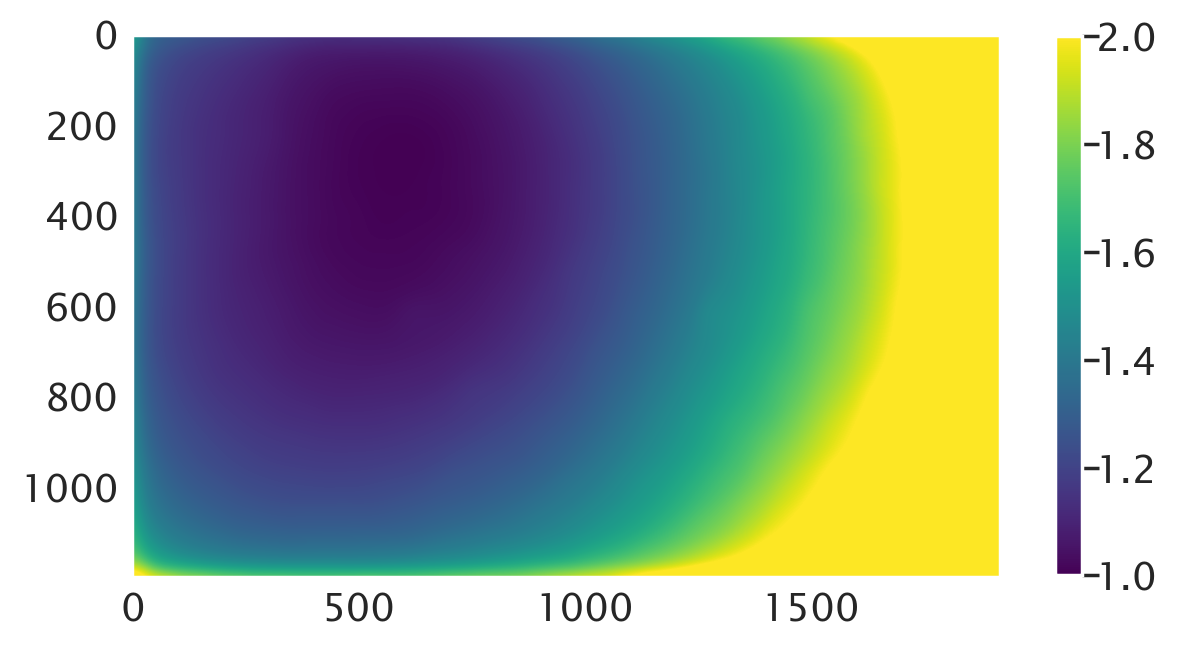

In [15]:
#Find the normilization matrix
YFP_norm_mat = atp_hydro.norm_mat_fn_iATP(YFP_array[-1], YFP_bg_offset)
CFP_norm_mat = atp_hydro.norm_mat_fn_iATP(CFP_array[-1], CFP_bg_offset)
#Mot_norm_mat = atp_hydro.norm_mat_fn_iATP(Mot_array[-1], Mot_bg_offset)

#plot the normalizaiton matrix
plt.imshow(CFP_norm_mat, vmin = 1, vmax = 2)
plt.colorbar(shrink = 0.7)
plt.grid(False)

multiply the images by the normalization matrix

In [16]:
#Normalize all the claibration images by multiplying by the normalization matrix
YFP_norm = YFP_bs*YFP_norm_mat
CFP_norm = CFP_bs*CFP_norm_mat
#Mot_norm = Mot_bs*Mot_norm_mat

### Find Center

Define a function that segments the imaging circle and finds the centroid of the region

def center(im_array):
    centers = []

    for i, im in enumerate(tqdm(im_array)):
        #Create a binary mask for above a threshold
        thresh = threshold_otsu(im) #Otsu threshold method
        binary = (im>thresh).astype(np.uint8)
        
        
        properties = regionprops(binary, im)
        center = properties[0].centroid
        center = [round(center[0]), round(center[1])]
        centers.append(center)
        
    return centers

Find centers of YFP and CFP images

YFP_centers = center(YFP_norm)
CFP_centers = center(CFP_norm)
print('center shifts: YFP + ' + str([YFP_centers[0][0]-CFP_centers[0][0], YFP_centers[0][1]-CFP_centers[0][1]]) + ' = CFP')

Crop and shift the image to register the images

radius = 385
sidelength = int(radius/np.sqrt(2))

YFP_circlecrop = []
for i, im in enumerate(tqdm(YFP_norm)):
    im_crop = im[YFP_centers[i][0] - radius : YFP_centers[i][0] + radius,
                YFP_centers[i][1] - radius : YFP_centers[i][1] + radius]
    YFP_circlecrop.append(im_crop)
    
YFP_squarecrop = []
for i, im in enumerate(tqdm(YFP_norm)):
    im_crop = im[YFP_centers[i][0] - sidelength : YFP_centers[i][0] + sidelength,
                YFP_centers[i][1] - sidelength : YFP_centers[i][1] + sidelength]
    YFP_squarecrop.append(im_crop)
    
CFP_circlecrop = []
for i, im in enumerate(tqdm(CFP_norm)):
    im_crop = im[int(CFP_centers[i][0]) - radius : int(CFP_centers[i][0]) + radius ,
                int(CFP_centers[i][1]) - radius : int(CFP_centers[i][1]) + radius]
    CFP_circlecrop.append(im_crop)

CFP_squarecrop = []
for i, im in enumerate(tqdm(CFP_norm)):
    im_crop = im[int(CFP_centers[i][0]) - sidelength : int(CFP_centers[i][0]) + sidelength ,
                int(CFP_centers[i][1]) - sidelength : int(CFP_centers[i][1]) + sidelength]
    CFP_squarecrop.append(im_crop)

Take the ratio of YFP/CFP images

ratio_circlecrop =[]
for i in range(len(YFP_circlecrop)):
    im = (YFP_circlecrop[i]/CFP_circlecrop[i])
    im[np.where(im==np.inf)] = 0
    ratio_circlecrop.append(im)
ratio_circlecrop = np.array(ratio_circlecrop)
plt.imshow(ratio_circlecrop[0])

ratio_squarecrop =[]
for i in range(len(YFP_squarecrop)):
    im = (YFP_squarecrop[i]/CFP_squarecrop[i])
    im[np.where(im==np.inf)] = 0
    ratio_squarecrop.append(im)
ratio_squarecrop = np.array(ratio_squarecrop)
plt.imshow(ratio_squarecrop[0])

## Calculate the average intensity value per concentration
Average images in the binary mask

#Average over the non-zero values in the image to get the calibration
YFP_calavg = np.empty(len(YFP_squarecrop))
for i, im in enumerate(YFP_squarecrop):
    YFP_calavg[i] = np.average(im[np.nonzero(im)])
    
CFP_calavg = np.empty(len(CFP_squarecrop))
for i, im in enumerate(CFP_squarecrop):
    CFP_calavg[i] = np.average(im[np.nonzero(im)])
    
#ratio_calavg = YFP_calavg/CFP_calavg

ratio_calavg = np.empty(len(YFP_squarecrop))
for i in range(len(YFP_norm)):
    im = YFP_squarecrop[i]/CFP_squarecrop[i]
    im[np.where(im==np.inf)] = 0
    ratio_calavg[i] = np.nanmean(im[np.nonzero(im)])
    
Mot_calavg = np.empty(len(Mot_norm))
for i, im in enumerate(Mot_norm):
    Mot_calavg[i] = np.average(im[np.nonzero(im)])

In [19]:
#Average over the non-zero values in the image to get the calibration
YFP_hydro = np.empty(len(YFP_norm))
for i, im in enumerate(YFP_norm):
    YFP_hydro[i] = np.average(im)
    
CFP_hydro = np.empty(len(CFP_norm))
for i, im in enumerate(CFP_norm):
    CFP_hydro[i] = np.average(im)
    
#ratio_calavg = YFP_calavg/CFP_calavg

ratio_hydro = np.empty(len(YFP_norm))
for i in range(len(YFP_norm)):
    im = YFP_norm[i]/CFP_norm[i]
    im[np.where(im==np.inf)] = 0
    ratio_hydro[i] = np.nanmean(im)
    
# Mot_calavg = np.empty(len(Mot_norm))
# for i, im in enumerate(Mot_norm):
#     Mot_calavg[i] = np.average(im[np.nonzero(im)])

/var/folders/8p/dg75nl0d7ml8f_vqy6lvm3740000gn/T/ipykernel_13582/3743235280.py:14: RuntimeWarning: divide by zero encountered in true_divide
  im = YFP_norm[i]/CFP_norm[i]


In [27]:
time = np.arange(0, len(ratio_hydro), 1)*60 #s

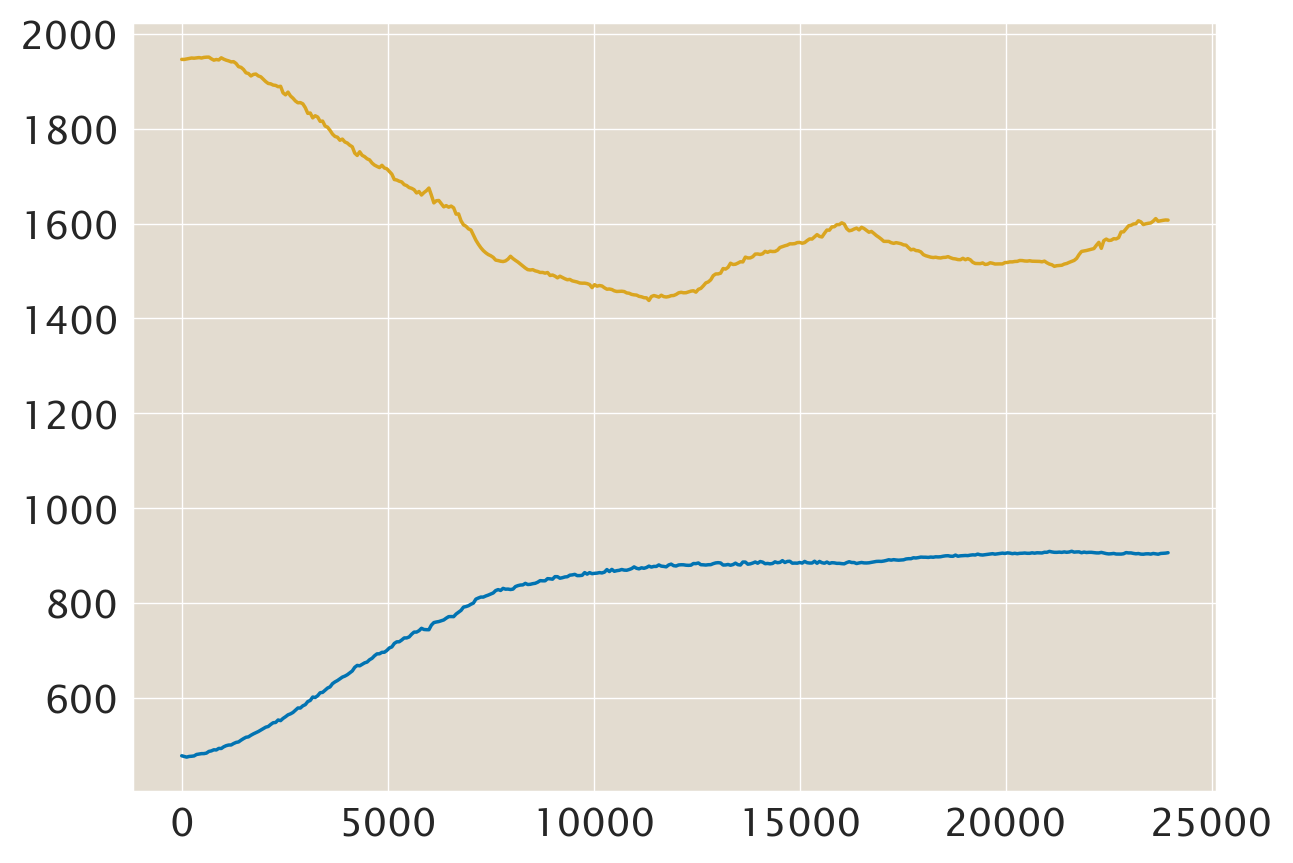

In [28]:
#plt.plot(np.arange(0, len(ratio_calavg), 1), ratio_calavg)
plt.plot(time, YFP_hydro, c='goldenrod')
plt.plot(time, CFP_hydro, c='b')

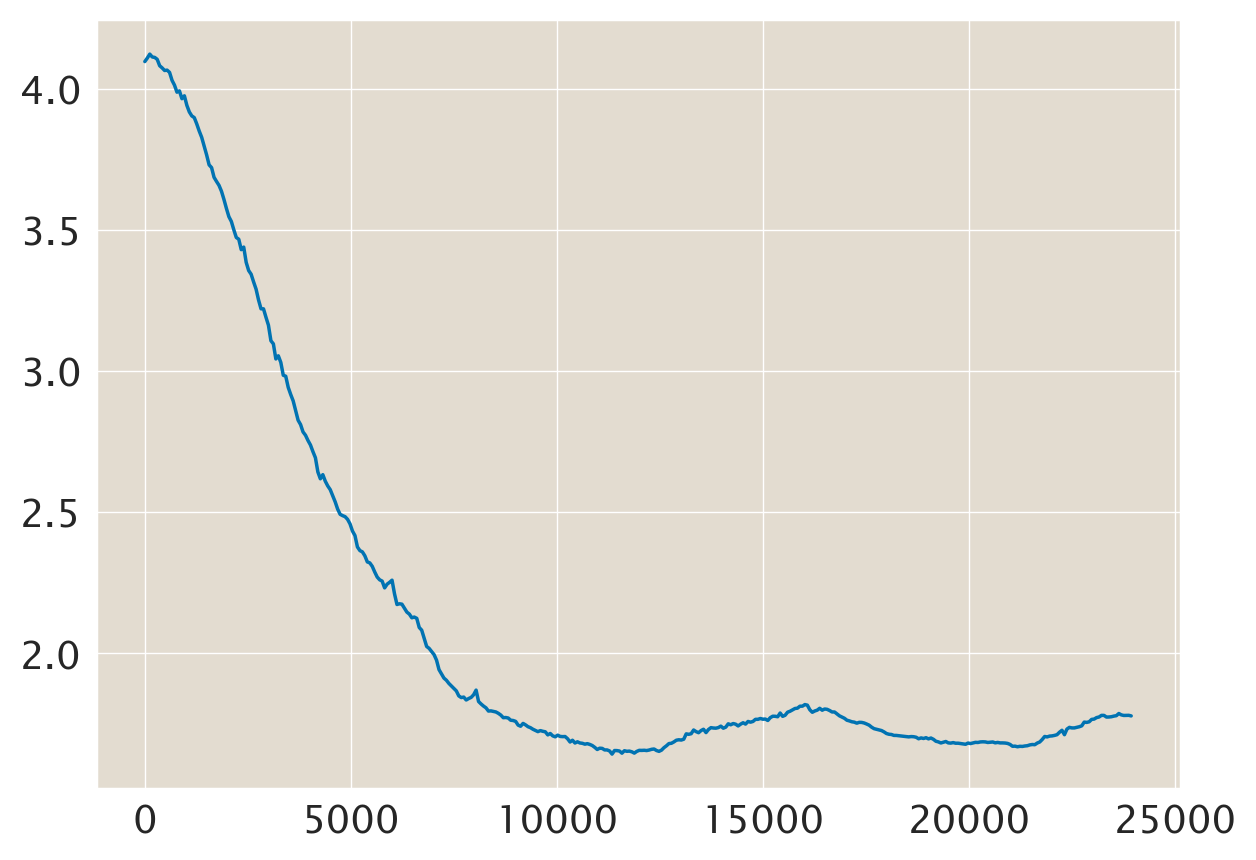

In [29]:
plt.plot(time, ratio_hydro)

### Convert to Intensity

In [25]:
def ATP_inten_to_conc(array, a, b, c, d):
    return a * ((c - array) / (array - b)) ** (1/d)

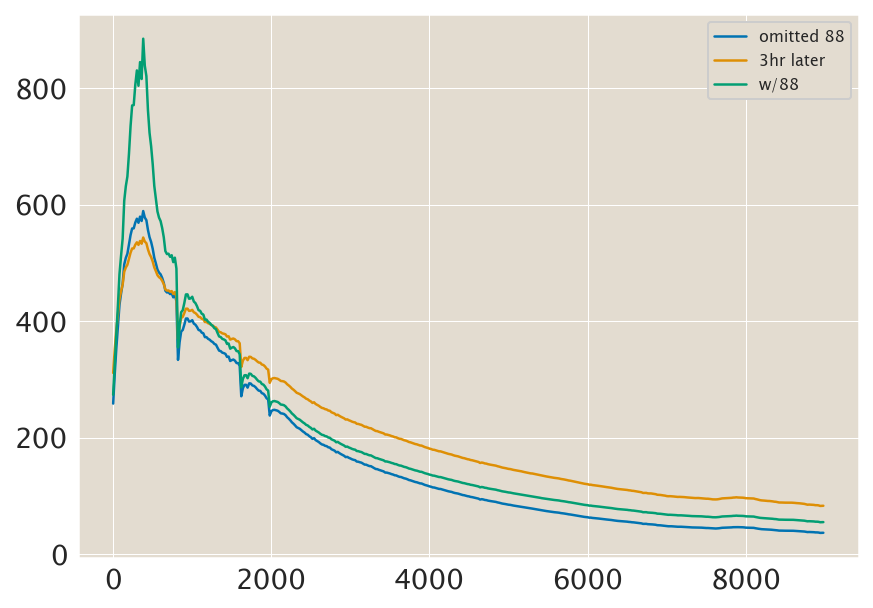

In [40]:
ratio_concavg1 = ATP_inten_to_conc(ratio_hydro, 80.37, 2.63, 0.8, 1.64)
plt.plot(time, ratio_concavg1, label = 'omitted 88')
ratio_concavg2 = ATP_inten_to_conc(ratio_calavg, 141, 2.63, 0.8, 2.42)
plt.plot(time, ratio_concavg2, label = '3hr later')
ratio_concavg3 = ATP_inten_to_conc(ratio_calavg, 98.24, 2.58, 0.79, 2.11)
plt.plot(time, ratio_concavg3, label = 'w/88')
plt.legend()

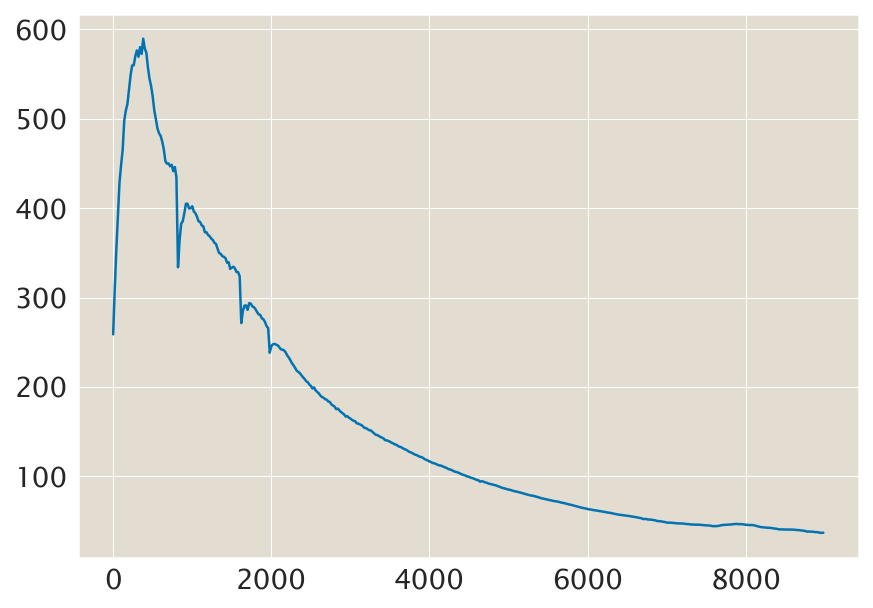

In [41]:
ratio_concavg1 = ATP_inten_to_conc(ratio_calavg, 80.37, 2.63, 0.8, 1.64)
plt.plot(time, ratio_concavg1, label = 'omitted 88')

In [109]:
def expfunc(time, tau, Ao):
    return Ao*np.exp(-time/tau)
def expfit(time, norm_conc, p0):
    #Curve fits and returns parameter values as well as the covarience
    param, param_cov = curve_fit(expfunc, 
                                 time, 
                                 norm_conc, 
                                 p0, 
                                 bounds = (np.zeros(2), np.ones([2])*np.inf))

    #stores the new function information according to the coefficients given by curve-fit() function 
    curve = expfunc(time, param[0], param[1])
    
    return param, curve

In [115]:
params, curve = expfit(time[19:], ratio_concavg1[19:], [2000, 600])

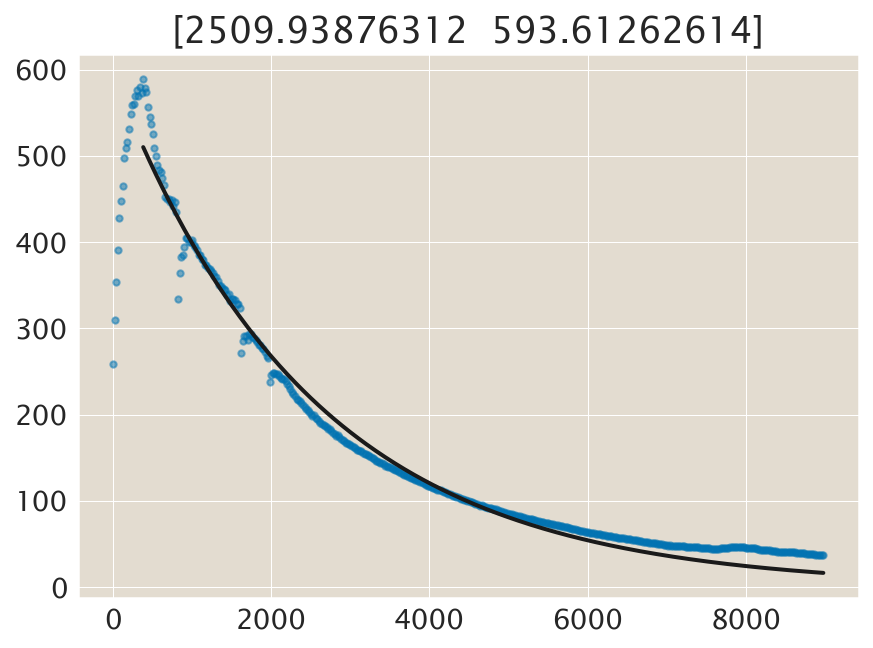

In [119]:
plt.scatter(time, ratio_concavg1, alpha=0.5, s=10)
plt.plot(time[19:], curve, color='k', linewidth=2)
plt.title(str(params));

In [120]:
ATPsat = params[1] #uM
mot_conc = 34*(1/10)*(1/7) #uM --> 34um*(1ul/10ul)*(1ul/7ul)
Decay=params[0] #s
slope = ATPsat/Decay #uM/s
rate = ATPsat/Decay/mot_conc
print("ATP/mot*s Hydrolysis rate: " +str(rate))

ATP/mot*s Hydrolysis rate: 0.48692169705702976


In [42]:
np.max(ratio_concavg1), np.where(ratio_concavg1 == np.max(ratio_concavg1))

(589.5306517986455, (array([19]),))

## Fit to exponential

In [64]:
def expfunc(time, tau):
    return np.exp(-time/tau)
def expfit(time, norm_conc, p0):
    #Curve fits and returns parameter values as well as the covarience
    param, param_cov = curve_fit(expfunc, 
                                 time, 
                                 norm_conc, 
                                 p0, 
                                 bounds = (np.zeros(1), np.ones([1])*np.inf))

    #stores the new function information according to the coefficients given by curve-fit() function 
    curve = expfunc(time, param[0])
    
    return param, curve

In [105]:
norm_conc = ratio_concavg1/(np.max(ratio_concavg1))
params, curve = expfit(time[19:], norm_conc[19:], [2000])

In [106]:
params[0]

2527.8111003047134

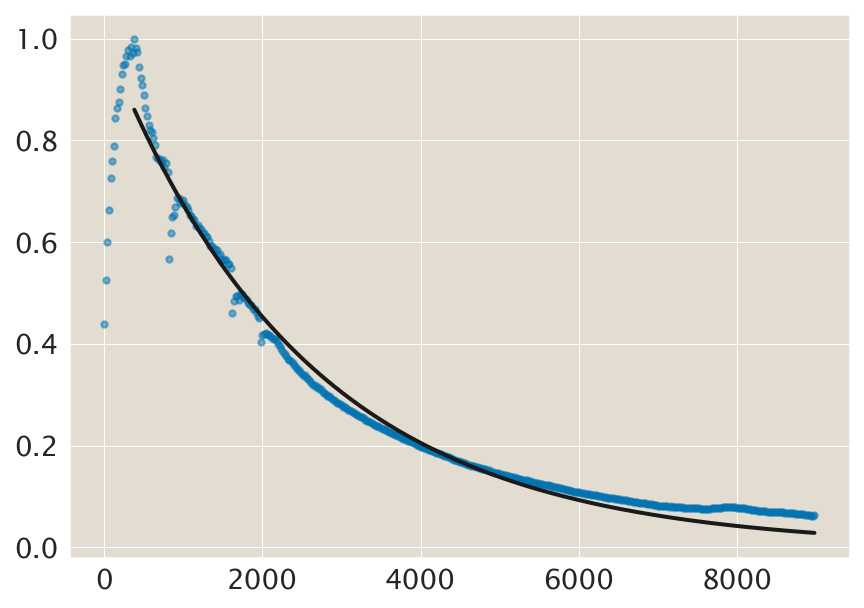

In [107]:
plt.scatter(time, norm_conc, alpha=0.5, s=10)
plt.plot(time[19:], curve, color='k', linewidth=2)

In [108]:
ATPsat = np.max(ratio_concavg1) #uM
mot_conc = 34*(1/10)*(1/7) #uM --> 34um*(1ul/10ul)*(1ul/7ul)
Decay=params[0] #s
slope = ATPsat/Decay #uM/s
rate = ATPsat/Decay/mot_conc
print("ATP/mot*s Hydrolysis rate: " +str(rate))

ATP/mot*s Hydrolysis rate: 0.4801543822187488
